# Single Box

In [61]:
from MEDSAM_helper_functions import * # show_mask, show_box, medsam_inference

import sys, os
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '..'))
if not dir1 in sys.path: sys.path.append(dir1)

from utils.environment import setup_data_vars

setup_data_vars()

## Get Example Slice For Inference

In [62]:
import SimpleITK as sitk

# axis, img_slice = 0, 100
# axis, img_slice = 1, 240
# axis, img_slice = 2, 240

def get_image_slice(img_class, image_id=10, axis=1, img_slice=240):
    image_prefix = 'zzAMLART_'
    nii_postfix = '_0000.nii.gz'
    gt_postfix = '.nii.gz'

    image_path = os.path.join(os.environ.get('nnUNet_raw'), os.environ.get(img_class), os.environ.get('data_trainingImages'), image_prefix + str(image_id).zfill(3) + nii_postfix)
    gt_path = os.path.join(os.environ.get('nnUNet_raw'), os.environ.get(img_class), os.environ.get('data_trainingLabels'), image_prefix + str(image_id).zfill(3) + gt_postfix)

    gt_label = sitk.ReadImage(gt_path)
    array_gt_label = sitk.GetArrayFromImage(gt_label)

    image = sitk.ReadImage(image_path)
    array_image = sitk.GetArrayFromImage(image)


    slices = [slice(None)] * 3 # Create a list of slice(None) for all dimensions
    slices[axis] = img_slice

    # Extract 2D slice at axis
    image_slice = array_image[tuple(slices)]
    gt_slice = array_gt_label[tuple(slices)]

    return image_slice, gt_slice

In [63]:
def visualise_pre_processing(array_image, array_gt_label):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(array_image, cmap='gray')
    axes[0].set_title('Raw Image')

    alpha_mask_gt = np.where(array_gt_label > 0, 1, 0).astype(np.float32)
    axes[1].imshow(array_image, cmap='gray')
    axes[1].imshow(array_gt_label, alpha=alpha_mask_gt, cmap='viridis')
    axes[1].set_title('Ground Truth')

In [65]:
import cv2

def get_bounding_boxes(resized_gt):
    # Find contours in the segmentation map
    contours, _ = cv2.findContours(resized_gt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize list to store bounding boxes
    bounding_boxes = []

    # Loop through contours to find bounding boxes
    for contour in contours:
        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append([x, y, x + w, y + h])  # Format: (x_min, y_min, x_max, y_max)

    return np.array(bounding_boxes)

In [84]:
def visualise_bounding_box_with_prediction(array_image, array_gt_label, bounding_boxes=None, predicted_mask=None, show_boxes_of_predictions=False):
    ncols = sum([2, int(bounding_boxes is not None), int(predicted_mask is not None)])

    _, axes = plt.subplots(1, ncols, figsize=(5 * ncols, 5))
    axes[0].imshow(array_image, cmap='gray')
    axes[0].set_title('Raw Image')

    alpha_mask_gt = np.where(array_gt_label > 0, 1, 0).astype(np.float32)
    axes[1].imshow(array_image, cmap='gray')
    axes[1].imshow(array_gt_label, alpha=alpha_mask_gt, cmap='viridis')
    axes[1].set_title('Ground Truth')

    currcol = 2

    if bounding_boxes is not None:
        assert len(bounding_boxes) >= 1
        axes[2].imshow(array_image, cmap='gray')
        for box in bounding_boxes:
            box = list(box)
            x0, y0 = box[0], box[1]
            w, h = box[2] - box[0], box[3] - box[1]
            axes[2].add_patch(
                plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2)
            )
        axes[2].set_title('Bounding Box From Segmentation')
        currcol += 1

    if predicted_mask is not None:

        alpha_mask_pred = np.where(predicted_mask > 0, 1, 0).astype(np.float32)
        axes[currcol].imshow(array_image, cmap='gray')
        axes[currcol].imshow(predicted_mask, alpha=alpha_mask_pred, cmap='viridis')
        axes[currcol].set_title('Predicted Mask')

        if show_boxes_of_predictions:
            bounding_boxes_of_predictions = get_bounding_boxes(predicted_mask)

            for box in bounding_boxes_of_predictions:
                box = list(box)
                x0, y0 = box[0], box[1]
                w, h = box[2] - box[0], box[3] - box[1]
                axes[currcol].add_patch(
                    plt.Rectangle((x0, y0), w, h, edgecolor="red", facecolor=(0, 0, 0, 0), lw=2)
                )
                
    plt.tight_layout()

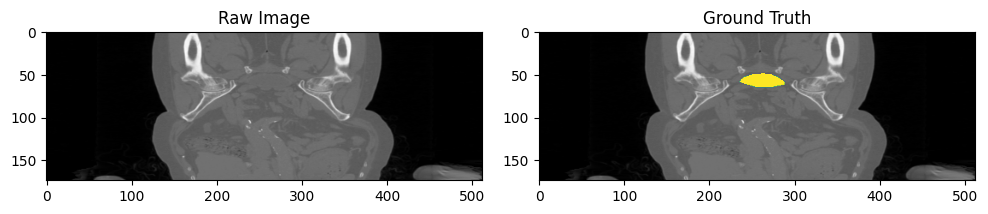

In [85]:
image_slice, gt_slice = get_image_slice('Bladder', axis=1, img_slice=240)
visualise_bounding_box_with_prediction(image_slice, gt_slice, None, None)

## Pre-processing Images

For CT images:
1. Normalized the Hounsfield units using typical window width and level values. The
employed window width and level values for soft tissues, lung, and brain are (W:400,
L:40), (W:1500, L:-160), and (W:80, L:40), respectively. 
2. The intensity values were rescaled to the range of [0, 255]. 
3. Finally, to meet the model’s input requirements, all images were resized to a uniform
size of 1024 × 1024 × 3. For 3D CT and MR images, each 2D slice was resized to 1024 ×
1024, and the channel was repeated three times to maintain consistency. 
4. Bi-cubic interpolation was used for
resizing images, while nearest-neighbor interpolation was applied for resizing masks to
preserve their precise boundaries and avoid introducing unwanted artifacts. 

### 1/2. Normalize Hounsfield units, Intesnity Values rescaled to [0, 255]

In [77]:
WINDOW_WIDTH = 400
WINDOW_LEVEL= 40

# Taken from pre_CT_MR.py
lower_bound = WINDOW_LEVEL - WINDOW_WIDTH / 2
upper_bound = WINDOW_LEVEL + WINDOW_WIDTH / 2
image_data_pre = np.clip(image_slice, lower_bound, upper_bound)
image_data_pre = (
    (image_data_pre - np.min(image_data_pre))
    / (np.max(image_data_pre) - np.min(image_data_pre))
    * 255.0
)

image_data_pre = np.uint8(image_data_pre)

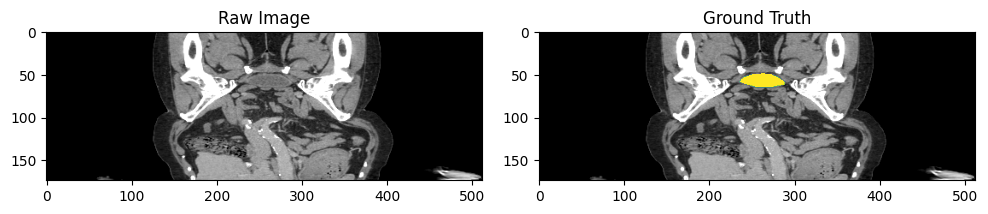

In [86]:
visualise_bounding_box_with_prediction(image_data_pre, gt_slice)

### 3. Resized to 1024 x 1024 x 3

In [38]:
image_size = 1024

img_3c = np.repeat(image_data_pre[:, :, None], 3, axis=-1)
resize_img_skimg = transform.resize(
    img_3c,
    (image_size, image_size),
    order=3,
    preserve_range=True,
    mode="constant",
    anti_aliasing=True,
)
resize_img_skimg_01 = (resize_img_skimg - resize_img_skimg.min()) / np.clip(
resize_img_skimg.max() - resize_img_skimg.min(), a_min=1e-8, a_max=None
)  # normalize to [0, 1], (H, W, 3)


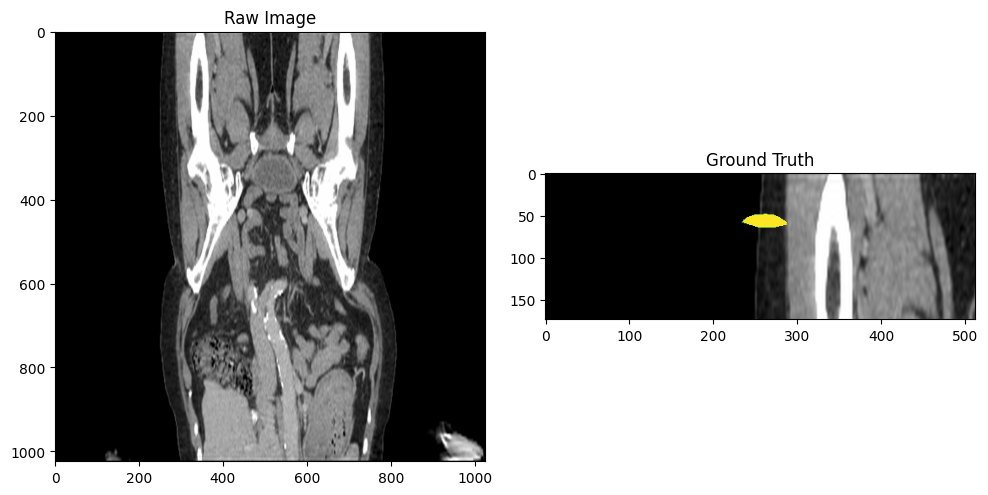

In [87]:
visualise_bounding_box_with_prediction(resize_img_skimg_01, gt_slice)

### 5. Same thing to GT, without the noramlization, only the size and interpolation

In [40]:
# remove small objects with less than 100 pixels in 2D slices

import cc3d

voxel_num_thre2d = 100

# remove small objects with less than 100 pixels
# reason: for such small objects, the main challenge is detection rather than segmentation
gt_slice = cc3d.dust(gt_slice, threshold=voxel_num_thre2d, connectivity=8, in_place=False)

resize_gt_skimg = transform.resize(
    gt_slice,
    (image_size, image_size),
    order=0,
    preserve_range=True,
    mode="constant",
    anti_aliasing=False,
)
resize_gt_skimg = np.uint8(resize_gt_skimg)

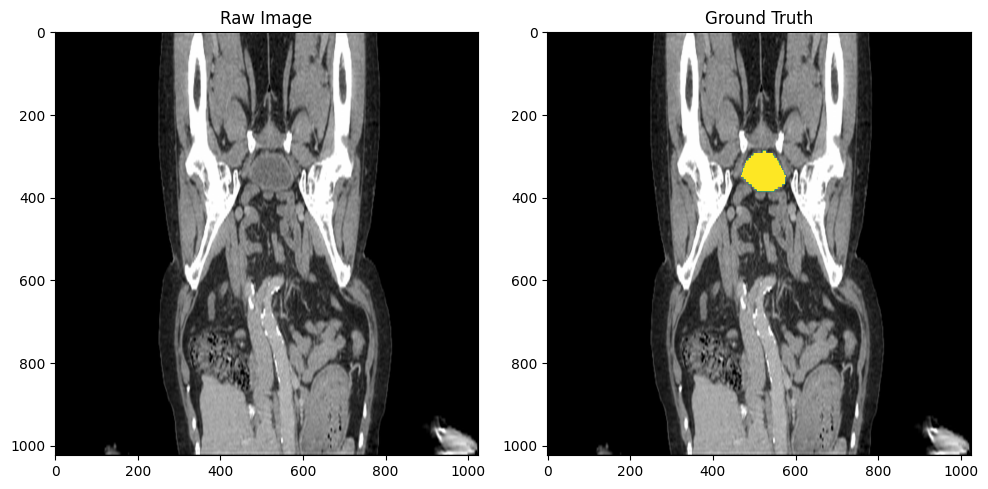

In [88]:
visualise_bounding_box_with_prediction(resize_img_skimg_01, resize_gt_skimg)

In [42]:
# Formalize the above in a function
import cc3d

def pre_process_image_and_gt(image_np, gt_np):
    WINDOW_WIDTH = 400
    WINDOW_LEVEL= 40

    # Taken from pre_CT_MR.py
    lower_bound = WINDOW_LEVEL - WINDOW_WIDTH / 2
    upper_bound = WINDOW_LEVEL + WINDOW_WIDTH / 2
    image_data_pre = np.clip(image_np, lower_bound, upper_bound)
    image_data_pre = (
        (image_data_pre - np.min(image_data_pre))
        / (np.max(image_data_pre) - np.min(image_data_pre))
        * 255.0
    )

    image_data_pre = np.uint8(image_data_pre)

    image_size = 1024

    img_3c = np.repeat(image_data_pre[:, :, None], 3, axis=-1)
    resize_img_skimg = transform.resize(
        img_3c,
        (image_size, image_size),
        order=3,
        preserve_range=True,
        mode="constant",
        anti_aliasing=True,
    )
    resize_img_skimg_01 = (resize_img_skimg - resize_img_skimg.min()) / np.clip(
    resize_img_skimg.max() - resize_img_skimg.min(), a_min=1e-8, a_max=None
    )  # normalize to [0, 1], (H, W, 3)

    voxel_num_thre2d = 100

    # remove small objects with less than 100 pixels
    # reason: for such small objects, the main challenge is detection rather than segmentation
    gt_slice = cc3d.dust(gt_np, threshold=voxel_num_thre2d, connectivity=8, in_place=False)

    resize_gt_skimg = transform.resize(
        gt_slice,
        (image_size, image_size),
        order=0,
        preserve_range=True,
        mode="constant",
        anti_aliasing=False,
    )
    resize_gt_skimg = np.uint8(resize_gt_skimg)

    return resize_img_skimg_01, resize_gt_skimg

In [43]:
resized_image, resized_gt = pre_process_image_and_gt(image_slice, gt_slice)

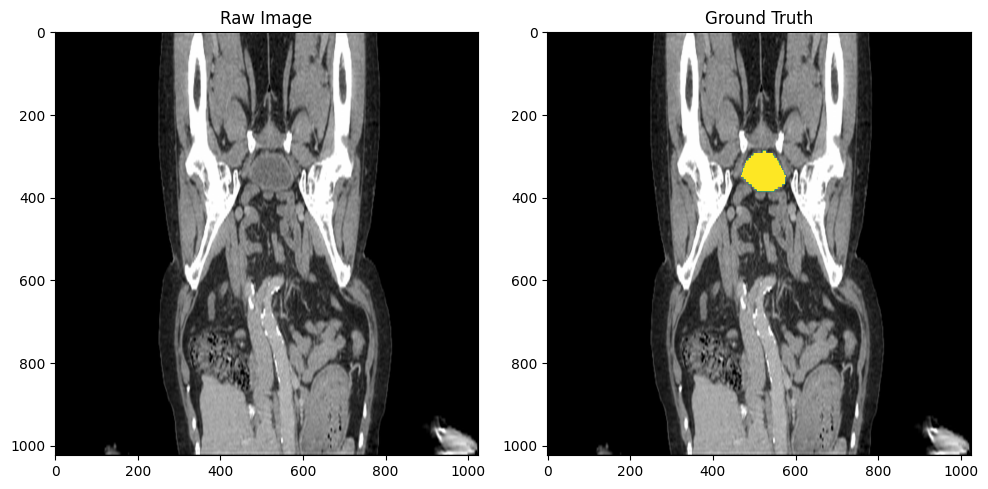

In [89]:
visualise_bounding_box_with_prediction(resized_image, resized_gt)

## Extract bounding box

In [45]:
import cv2

def get_bounding_boxes(resized_gt):
    # Find contours in the segmentation map
    contours, _ = cv2.findContours(resized_gt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize list to store bounding boxes
    bounding_boxes = []

    # Loop through contours to find bounding boxes
    for contour in contours:
        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append([x, y, x + w, y + h])  # Format: (x_min, y_min, x_max, y_max)

    return np.array(bounding_boxes)

In [46]:
box_np = get_bounding_boxes(resized_gt)

In [47]:
def visualise_bounding_box(array_image, array_gt_label, bounding_boxes):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(array_image, cmap='gray')
    axes[0].set_title('Raw Image')

    alpha_mask_gt = np.where(array_gt_label > 0, 1, 0).astype(np.float32)
    axes[1].imshow(array_image, cmap='gray')
    axes[1].imshow(array_gt_label, alpha=alpha_mask_gt, cmap='viridis')
    axes[1].set_title('Ground Truth')

    assert len(bounding_boxes) >= 1
    axes[2].imshow(array_image, cmap='gray')
    for box in bounding_boxes:
        box = list(box)
        x0, y0 = box[0], box[1]
        w, h = box[2] - box[0], box[3] - box[1]
        axes[2].add_patch(
            plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2)
        )
    axes[2].set_title('Bounding Box From Segmentation')

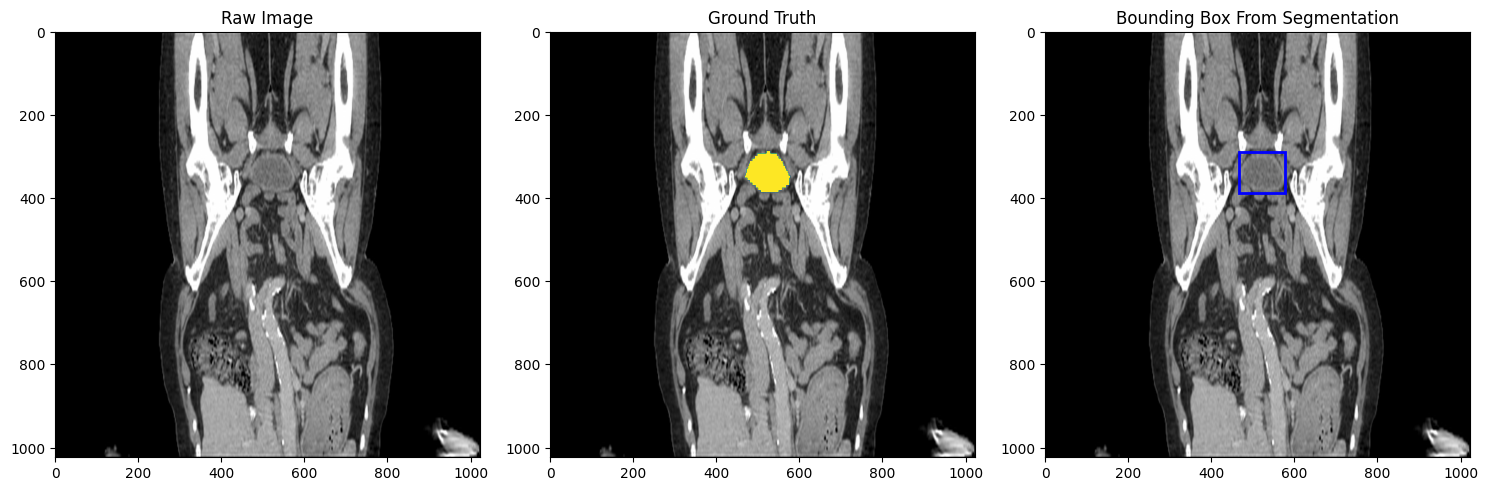

In [90]:
visualise_bounding_box_with_prediction(resize_img_skimg_01, resize_gt_skimg, box_np)
# visualise_bounding_box(resize_img_skimg_01, resize_gt_skimg, bounding_boxes)

## Setup Model

In [49]:
MedSAM_CKPT_PATH = os.path.join(os.environ.get('PROJECT_DIR'),  "models/MedSAM/work_dir/MedSAM/medsam_vit_b.pth")

In [50]:
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()
'medsam set to evaluation'

'medsam set to evaluation'

In [51]:
img_1024_tensor = torch.tensor(resize_img_skimg_01).float().permute(2, 0, 1).unsqueeze(0).to(device)

with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)

H, W, _ = resize_img_skimg_01.shape
medsam_seg = medsam_inference(medsam_model, image_embedding, box_np, H, W)

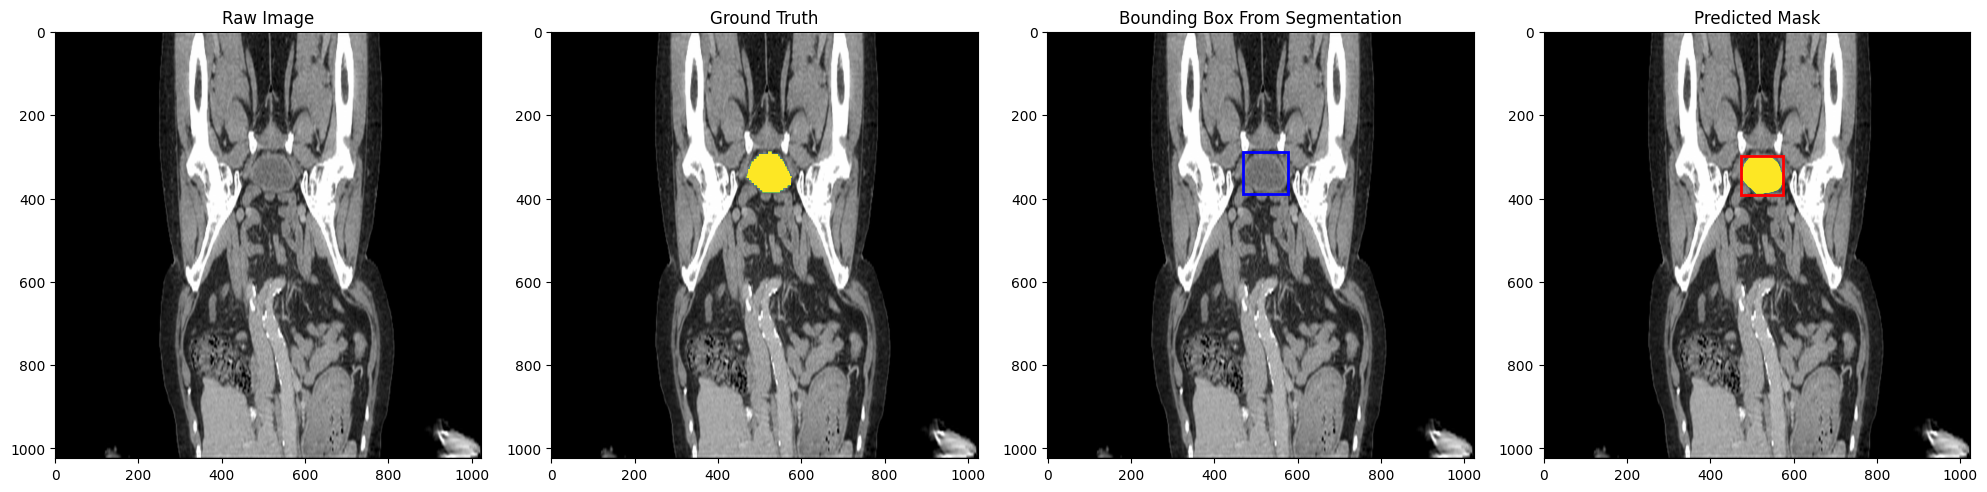

In [91]:
visualise_bounding_box_with_prediction(resize_img_skimg_01, resize_gt_skimg, box_np, medsam_seg, True)

In [55]:
import SimpleITK as sitk

def dice_similarity(gt, pred):
    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

    ypred_sitk = sitk.GetImageFromArray(pred)
    y_gt_sitk = sitk.GetImageFromArray(gt)

    overlap_measures_filter.Execute(y_gt_sitk, ypred_sitk)
    return overlap_measures_filter.GetDiceCoefficient()

dice_score = dice_similarity(resize_gt_skimg, medsam_seg)
print("Dice Similarity Score:", dice_score)

Dice Similarity Score: 0.9423459244532804


## How about when we resize this back to the original size?

In [56]:
def resize_prediction_to_original(gt_segmentation, prediction):
    # Resize the prediction to the original size
    prediction_resized = transform.resize(
        prediction,
        gt_segmentation.shape,
        order=0,
        preserve_range=True,
        mode="constant",
        anti_aliasing=False,
    )
    prediction_resized = np.uint8(prediction_resized)

    return prediction_resized

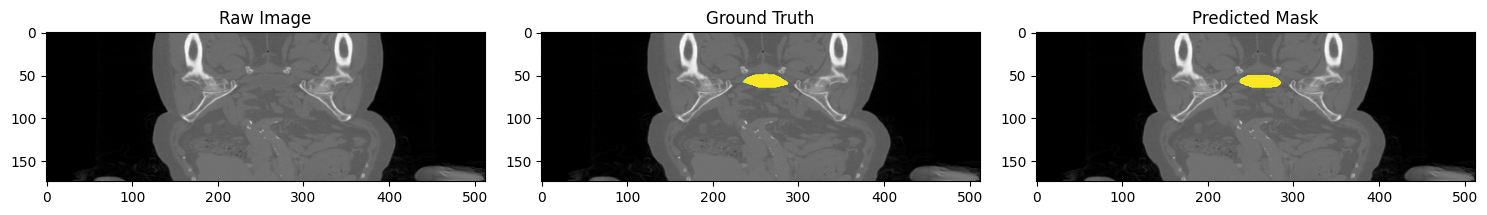

In [92]:
resized_prediction = resize_prediction_to_original(gt_slice, medsam_seg)
visualise_bounding_box_with_prediction(image_slice, gt_slice, None, resized_prediction, False)

In [59]:
dice_score = dice_similarity(gt_slice, resized_prediction)
print("Dice Similarity Score:", dice_score)

Dice Similarity Score: 0.9457973291437549


# Multiple Boxes

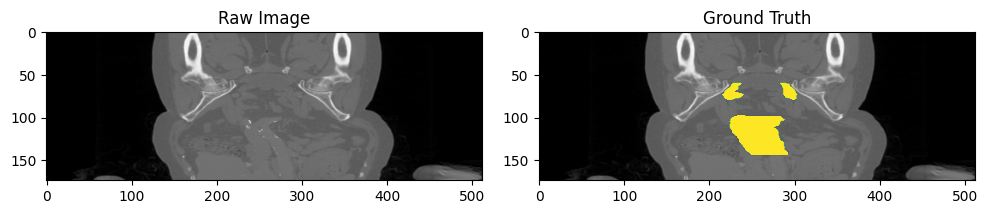

In [93]:
image_slice, gt_slice = get_image_slice('CTVn', axis=1, img_slice=240)
visualise_bounding_box_with_prediction(image_slice, gt_slice)

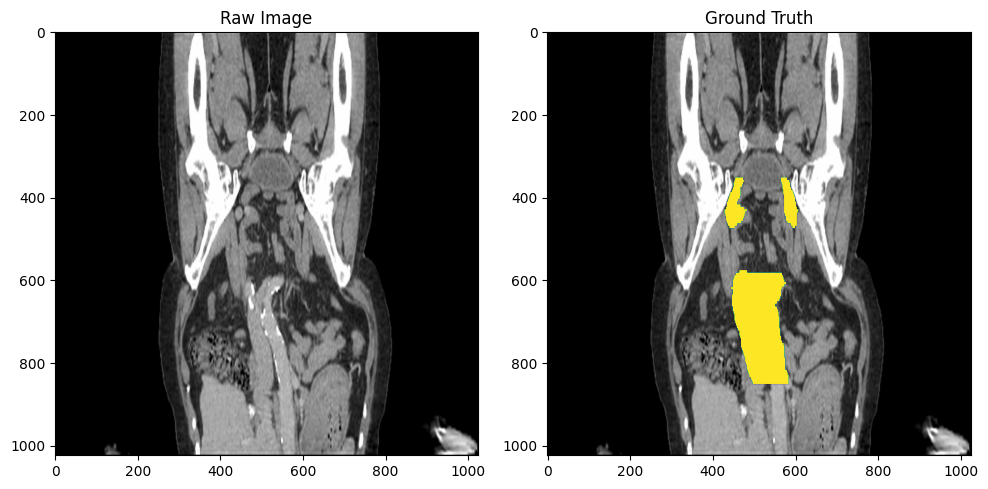

In [94]:
resized_image, resized_gt = pre_process_image_and_gt(image_slice, gt_slice)
visualise_bounding_box_with_prediction(resized_image, resized_gt)

In [210]:
import cv2

def get_bounding_boxes(resized_gt):
    # Find contours in the segmentation map
    contours, _ = cv2.findContours(resized_gt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize list to store bounding boxes
    bounding_boxes = []

    # Loop through contours to find bounding boxes
    for contour in contours:
        # Get bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append([x, y, x + w, y + h])  # Format: (x_min, y_min, x_max, y_max)

    return np.array(bounding_boxes)

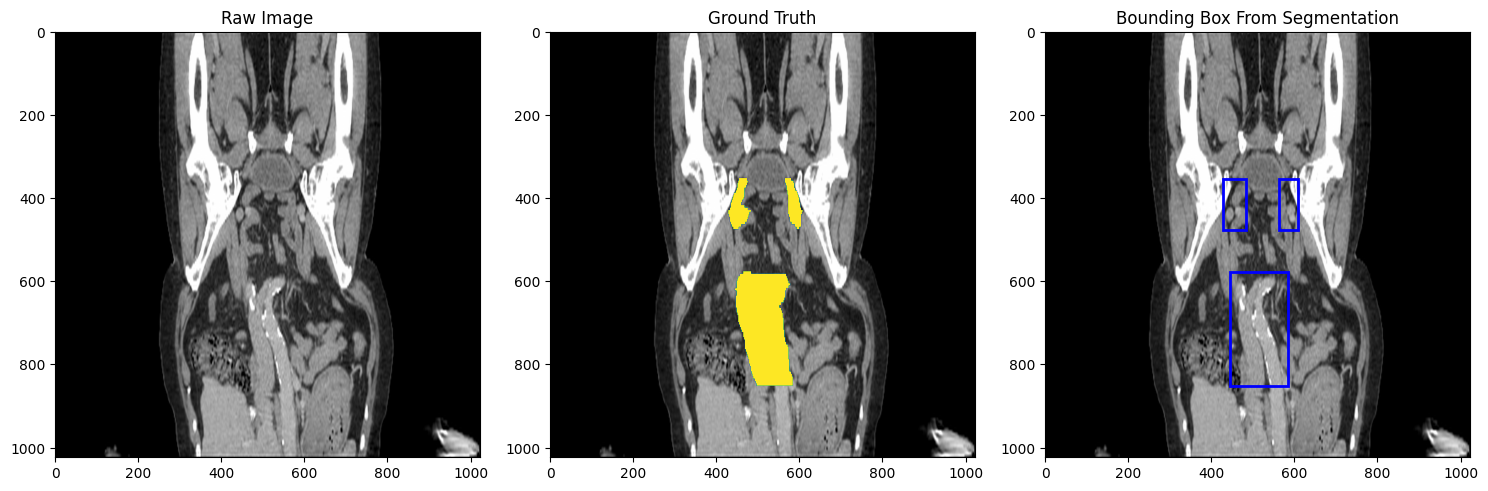

In [95]:
bounding_boxes = get_bounding_boxes(resized_gt)
visualise_bounding_box_with_prediction(resized_image, resized_gt, bounding_boxes)

In [96]:
img_1024_tensor = torch.tensor(resized_image).float().permute(2, 0, 1).unsqueeze(0).to(device)

with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)

H, W, _ = resize_img_skimg_01.shape

medsam_preds = [medsam_inference(medsam_model, image_embedding, box[None, :] , H, W) for box in bounding_boxes]

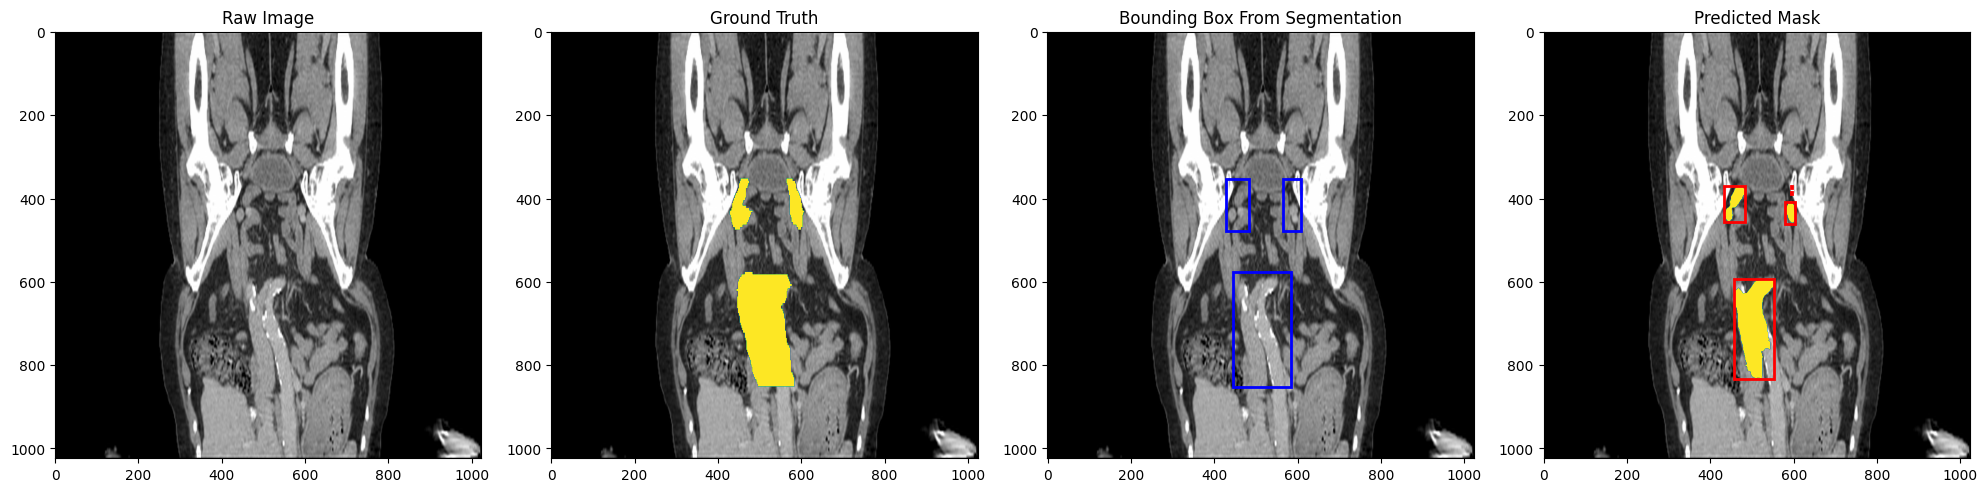

In [97]:
import numpy as np

combined_preds = np.logical_or.reduce(np.array(medsam_preds)).astype(np.uint8)

visualise_bounding_box_with_prediction(resized_image, resized_gt, bounding_boxes, combined_preds, True)
# for i, pred in enumerate(medsam_preds):
#     visualise_bounding_box_with_prediction(resized_image, resized_gt, bounding_boxes[i], pred)

In [98]:
dice_score = dice_similarity(resized_gt, combined_preds)
print("Dice Similarity Score:", dice_score)

Dice Similarity Score: 0.6060117470920189


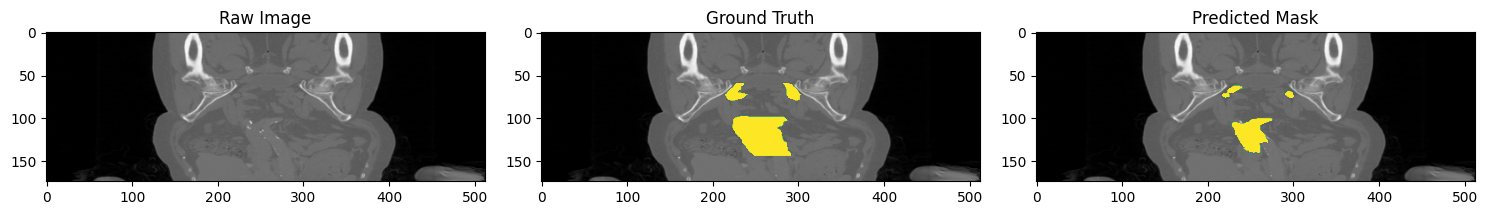

In [99]:
resized_prediction = resize_prediction_to_original(gt_slice, combined_preds)
visualise_bounding_box_with_prediction(image_slice, gt_slice, None, resized_prediction, False)

In [101]:
dice_score = dice_similarity(gt_slice, resized_prediction)
print("Dice Similarity Score:", dice_score)

Dice Similarity Score: 0.6062246278755075
